In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import torch
import scipy
import scipy.stats
from scipy.signal import find_peaks
from scipy.sparse import csr_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
import gffutils
from tqdm import tqdm
import itertools
import coolbox
from coolbox.api import *
import warnings
import sqlite3
import json

warnings.filterwarnings('ignore')

In [2]:
def set_diagonal(mat, value=0):
    if mat.shape[0] - mat.shape[1]:
        raise ValueError(
            'Matrix is not square ({}, {})'.format(mat.shape[0], mat.shape[1])
        )
    l = mat.shape[0]
    idx = np.arange(l)
    mat[idx[:-1], idx[1:]], mat[idx[1:], idx[:-1]] = value, value

    return mat


def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    pred = set_diagonal(summed[pred_len:-pred_len, pred_len:-pred_len])

    return pred


def load_database(db_file, gtf_file):
    if osp.isfile(db_file):
        db = gffutils.FeatureDB(db_file)
    else:
        print('creating db from raw. This might take a while.')
        db = gffutils.create_db(gtf_file, db_file)
    
    return db

In [150]:
input_dir = '/data/leslie/suny4/processed_input/'
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
ct1 = 'alexia_am_gfp_myc_thelp'
ct2 = 'alexia_am_gfp_myc_nothelp'
chrom = 13
db_file = '/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.db'

In [151]:
%%time

pred1 = load_pred(pred_dir, ct1, chrom, avg_stripe=True)
pred2 = load_pred(pred_dir, ct2, chrom, avg_stripe=True)

CPU times: user 2.9 s, sys: 1.68 s, total: 4.58 s
Wall time: 4.67 s


In [152]:
def quantile_normalize(preds, offset=2):
    N, H, W = preds.shape
    assert H == W, f'Matrix is not square ({H}, {W})'
    pred_diag = np.column_stack((
        np.array([
            np.pad(np.diagonal(pred, offset=i), (0, i), 'constant') for i in range(offset, 200)
        ]).T.ravel() for pred in preds
    ))
    df, df_mean = pd.DataFrame(pred_diag), pd.DataFrame(np.sort(pred_diag, axis=0)).mean(axis=1)
    df_mean.index += 1
    pred_diag_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack().values
    pred_diag_qn = pred_diag_qn.T.reshape(N, -1, 200-offset)
    preds_qn = np.zeros_like(preds)
    for i in range(offset, 200):
        idx = np.arange(H - i, dtype=int)
        preds_qn[:, idx, idx+i] = preds_qn[:, idx+i, idx] = pred_diag_qn[:, :H-i, i-offset]
    
    return preds_qn

In [153]:
%%time

preds_qn = quantile_normalize(np.array([pred1, pred2]))
pred1, pred2 = preds_qn[0], preds_qn[1]
pred_diff = pred1 - pred2

CPU times: user 2.85 s, sys: 703 ms, total: 3.56 s
Wall time: 3.56 s


In [154]:
def topdom(pred_mat, window_size=10, cutoff=None):
    if pred_mat.shape[0]-pred_mat.shape[1]:
        raise ValueError(
            'Matrix is not square ({}, {})'.format(pred_mat.shape[0], pred_mat.shape[1])
        )
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i, i:i+window_size]) for i in range(dim)
    ][window_size+1: -window_size])
    if cutoff is not None:
        signal[signal<cutoff] = cutoff

    return signal


def get_tads(mat, sizes, prominence=0.25):
    signal = np.array([topdom(mat, i) for i in sizes])
    rows, idxs = [], []
    for i in range(len(signal)):
        idx = find_peaks(signal[i], prominence=(prominence,))[0]
        row = np.full_like(idx, i)
        rows.append(row)
        idxs.append(idx)
    tads = np.array([
        np.concatenate(rows, axis=None), np.concatenate(idxs, axis=None)
    ])

    return tads


def tads_to_coords(tads, sizes):
    coords = np.array([
        tads[1] - sizes[tads[0]], tads[1] + sizes[tads[0]]
    ])

    return coords


def merge_coords(coords, sizes, close=5):
    df = pd.DataFrame({'x': coords[0], 'y': coords[1]})
    merged = df.groupby('x', as_index=False).agg({'y': 'max'})
    merged['s'] = (merged.y - merged.x) // 2
    merged = merged.sort_values(by=['x']).reset_index(drop=True)

    i = 0
    curx, cury, curs = merged.iloc[i]

    while i+1 < merged.shape[0]:
        x, y, s = merged.iloc[i+1]
        if s == curs:
            if abs(x - curx) <= close:
                curx, cury = min(curx, x), max(cury, y)
                curs = (cury - curx) // 2
                merged = merged.drop(i+1, axis=0).reset_index(drop=True)
            else:
                curx, cury, curs = x, y, s
                i += 1
        else:
            if abs(x - curx) <= close or abs(y - cury) <= close:
                curx, cury = min(curx, x), max(cury, y)
                curs = (cury - curx) // 2
                merged = merged.drop(i+1, axis=0).reset_index(drop=True)
            else:
                curx, cury, curs = x, y, s
                i += 1
        merged.iloc[i] = [curx, cury, curs]
    
    return merged.values.T


def get_tad_coords(pred, min_dim=10, max_dim=100, num_dim=10, close=5):

    def generate_sizes(min_dim, max_dim, num_dim):
        min_dim, max_dim = max(1, min_dim), min(100, max_dim)
        return np.linspace(min_dim, max_dim, num=num_dim, dtype=int)
    
    sizes = generate_sizes(min_dim, max_dim, num_dim)
    tads = get_tads(pred, sizes)
    allcoords = tads_to_coords(tads, sizes)
    coords = merge_coords(allcoords, sizes, close)

    return coords


def score_stripe(stripe):
    lower, upper = np.nanpercentile(stripe, [10, 90])
    masked = stripe[(stripe >= upper) | (stripe <= lower)]
    score, abs_score = np.nanmean(masked), np.nanmean(np.abs(masked))

    return score, abs_score


def rank_coords(pred, coords):
    xs, ys, ss, scores, abs_scores = [], [], [], [], []
    l = pred.shape[0]
    for i in range(coords.shape[1]):
        x, y, s = coords[:, i]
        stripe = []
        for i in np.arange(x, y+1, dtype=int):
            left = pred[max(0, i-200):i+1, i]
            right = pred[i, i:min(i+201, l)]
            left = np.pad(left, (201 - len(left), 0), 'empty')
            right = np.pad(right, (0, 201 - len(right)), 'empty')
            stripe.append(np.array([left, right]).flatten())
        stripe = np.array(stripe)
        score, abs_score = score_stripe(stripe)
        xs.append(x)
        ys.append(y)
        ss.append(s)
        scores.append(score)
        abs_scores.append(abs_score)
    df = pd.DataFrame({
        'x_coord': xs, 'y_coord': ys, 'window_size': ss,
        'score': scores, 'abs_score': abs_scores
    })

    return df

In [155]:
def load_database(db_file, gtf_file):
    if osp.isfile(db_file):
        db = gffutils.FeatureDB(db_file)
    else:
        print('creating db from raw. This might take a while.')
        db = gffutils.create_db(gtf_file, db_file)
    
    return db


def parse_query(line):
    start, end, chrom, table, featuretype = line
    select_from = 'SELECT * FROM {} WHERE'.format(table)
    start_req = 'start >= {}'.format(start)
    end_req = 'end <= {}'.format(end)
    len_req = 'end - start >= 1000'
    chrom_req = 'seqid = \"chr{}\"'.format(chrom)
    feature_req = 'featuretype = \"{}\"'.format(featuretype)
    where_reqs = ' AND '.join([start_req, end_req, len_req, chrom_req, feature_req])
    query = ' '.join([select_from, where_reqs])
    
    return query


def parse_query_tad(line):
    _, _, _, _, _, left, right, chrom, table, featuretype = line
    select_from = f'SELECT * FROM {table} WHERE'
    start_req = f'start >= {left} AND start <= {right}'
    end_req = f'end >= {left} AND end <= {right}'
    len_req = 'end - start >= 1000'
    chrom_req = f'seqid = \"chr{chrom}\"'
    feature_req = f'featuretype = \"{featuretype}\"'
    where_reqs = ' AND '.join([start_req, end_req, len_req, chrom_req, feature_req])
    query = ' '.join([select_from, where_reqs])
    
    return query


def generate_query(regions, chrom, table='features', featuretype='gene'):
    regions['chrom'] = chrom
    regions['table'] = table
    regions['featuretype'] = featuretype
    reqs = regions.apply(parse_query, 1)

    return reqs


def generate_query_tad(ranked, chrom, table='features', featuretype='gene'):
    ranked['left'] = (ranked.x_coord - 1) * int(1e4)
    ranked['right'] = (ranked.y_coord + 1) * int(1e4)
    ranked['chrom'] = chrom
    ranked['table'] = table
    ranked['featuretype'] = featuretype
    ranked['reqs'] = ranked.apply(parse_query_tad, 1)

    return ranked


def merge_attr(attrs):
    if not attrs:
        raise ValueError(
            'No attributes detected. Please consider expanding your search by changing the filters'
        )
    return {k: [attr[k][0] if k in attr else None for attr in attrs] for k in attrs[0].keys()}


def check_attr(attr, filters):
    for restr in filters:
        if '=' not in restr:
            raise ValueError(
                'Cannot parse filter {}. Please doublecheck the input'.format(restr)
            )
        k, v = restr.strip().split('=')
        k, v = k.strip(), v.strip()
        if k not in attr:
            raise ValueError(
                'Cannot find key {} in attributes. Please doublecheck the input'.format(k)
            )
        if attr[k][0] != v: return False
    
    return True


def db_query_tad(db, ranked, chrom, table='features', featuretype='gene', filters=[]):
    ranked = generate_query_tad(ranked, chrom=chrom, table=table, featuretype=featuretype)
    select = [
        'chrom', 'start', 'end', 'gene_name', 'gene_id',
        'gene_type', 'level', 'score', 'abs_score'
    ]
    all_df = []
    for i in range(ranked.shape[0]):
        _, _, _, score, abs_score, _, _, chrom, table, featuretype, query = ranked.iloc[i]
        chrom, start, end, attrs = [], [], [], []
        valid = 0
        itr = db.execute(query).fetchall()
        for obj in itr:
            attr = json.loads(obj['attributes'])
            if filters:
                if not check_attr(attr, filters): continue
            chrom.append(obj['seqid'])
            start.append(obj['start'])
            end.append(obj['end'])
            attrs.append(attr)
            valid += 1
        if valid:
            info = pd.DataFrame({
                'chrom': chrom, 'start': start, 'end': end
            })
            attrs = pd.DataFrame(merge_attr(attrs))
            res = pd.concat([info, attrs], axis=1)
            res['score'] = score
            res['abs_score'] = abs_score
            res = res[select]
            all_df.append(res)
    if all_df:
        res = pd.concat(all_df, axis=0)
        res = res.groupby([
            'chrom', 'start', 'end', 'gene_name', 'gene_id', 'gene_type', 'level'
        ], as_index=False).agg({
            'score': 'sum', 'abs_score': 'sum'
        }).sort_values(by=['abs_score'], ignore_index=True, ascending=False)
        valid = res.shape[0]
        print(f'{ranked.shape[0]} databse query completed with {valid} match(es)')
    else:
        res, valid = None, 0
        warnings.warn(
            'No match found. Please consider expanding your search by changing the filters',
            RuntimeWarning
        )
    
    return res, valid      


def parse_res(row):
    start = int(max(row['start']//1e4 - 400, 0))
    locstart, locend = row['start']/1e4 - start, row['end']/1e4 - start
    gene = row['gene_name']

    return start, locstart, locend, gene

In [160]:
print('Calculating TADs...')
coords = get_tad_coords(pred_diff, min_dim=10, max_dim=90, num_dim=25, close=10)
ranked = rank_coords(pred_diff, coords)

print('Querying database...')
db_file = '/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.db'
gtf_file = '/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.gtf'
db = load_database(db_file, gtf_file)
res, numvalid = db_query_tad(db, ranked, chrom=chrom, table='features', featuretype='gene', filters=[
    'gene_type=protein_coding'
])

Calculating TADs...
Querying database...
237 databse query completed with 541 match(es)


In [161]:
res

,chrom,start,end,gene_name,gene_id,gene_type,level,score,abs_score
0,chr13,44922079,45002096,Dtnbp1,ENSMUSG00000057531.13,protein_coding,3,-0.011241,3.836936
1,chr13,43785107,43803130,Cd83,ENSMUSG00000015396.3,protein_coding,3,-0.003038,3.396198
2,chr13,44729474,44921643,Jarid2,ENSMUSG00000038518.15,protein_coding,2,0.050436,3.214002
3,chr13,112288451,112384002,Ankrd55,ENSMUSG00000049985.14,protein_coding,3,-0.701517,3.163099
4,chr13,112464070,112510086,Il6st,ENSMUSG00000021756.12,protein_coding,1,-0.735535,3.093519
...,...,...,...,...,...,...,...,...,...
536,chr13,60842621,60864416,4930486L24Rik,ENSMUSG00000050345.8,protein_coding,3,0.052555,0.197025
537,chr13,68582248,68592279,Fastkd3,ENSMUSG00000021532.10,protein_coding,3,0.052213,0.193479
538,chr13,68597439,68614231,1700001L19Rik,ENSMUSG00000021534.7,protein_coding,3,0.052213,0.193479
539,chr13,68620043,68999541,Adcy2,ENSMUSG00000021536.7,protein_coding,3,0.052213,0.193479


In [93]:
def rotate_coord(n):
    tmp = np.array(list(itertools.product(range(n,-1,-1),range(0,n+1,1))))
    tmp[:, [0, 1]] = tmp[:, [1, 0]]
    A = tmp.dot(np.array([[1, 0.5], [-1, 0.5]]))
    
    return A


def plot_pred_paired(predmat1, predmat2, preddiffmat, ct1, ct2, chrom, start, gene, locstart, locend):
    plt.rcParams['figure.figsize'] = 8, 9.5
    plt.rcParams['figure.autolayout'] = False

    fig, axs = plt.subplots(3, 1, sharex=True)
    fig.suptitle('chr{} - {}'.format(chrom, gene), fontsize=15)
    fig.tight_layout(rect=[0.01, 0.03, 1, 9/9.5], h_pad=2)
    
    vmaxs, vmins = [4, 4, 2], [-1, -1, -2]
    preds = [
        np.triu(predmat1[start:start+700, start:start+700]),
        np.triu(predmat2[start:start+700, start:start+700]),
        np.triu(preddiffmat[start:start+700, start:start+700])
    ]
    cts = [ct1, ct2, 'Difference']
    
    for i in range(3):
        ax, pred, ct = axs[i], preds[i], cts[i]
        n = pred.shape[0]
        A = rotate_coord(n)
        img = ax.pcolormesh(A[:, 1].reshape(n+1, n+1), A[:, 0].reshape(n+1, n+1),
                            np.flipud(pred), cmap='RdBu_r', vmax=vmaxs[i], vmin=vmins[i])
        ax.title.set_text(ct)
        ax.set_xlim(300, 500)
        ax.set_ylim(0, 200)
        ax.set_xticklabels(np.linspace(start+300, start+500, num=len(ax.get_xticks()), dtype=int))
        
        x = np.arange(300, 500)
        y1, y2 = np.absolute(2*x-2*locstart), np.absolute(2*x-2*locend)
        ax.plot(x, y1, color='magenta', alpha=0.3)
        ax.plot(x, y2, color='magenta', alpha=0.3)
        plt.colorbar(img, ax=ax)
        
    plt.xlabel('chr{} (10kb)'.format(chrom))
    plt.show()

    return

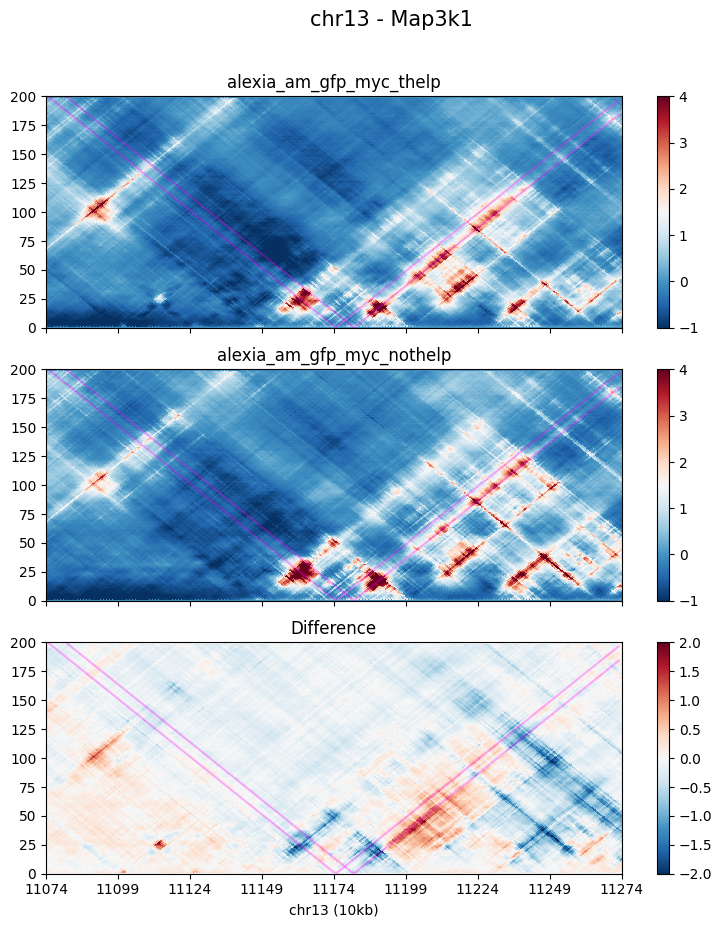

In [127]:
start, locstart, locend, gene = parse_res(aggres.iloc[5])
plot_pred_paired(pred1, pred2, pred_diff, ct1, ct2, chrom, start, gene, locstart, locend)